In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
import os
import random
from scipy import ndimage
from DataPreprocess import ImageData, MaskData, BBox, Reshape, SAMDataset
from helper import Helper

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
ROOT_DIR = '/content/gdrive/My Drive/coding/'

In [ ]:
!pip install git+https://github.com/facebookresearch/segment-anything.git
!pip install -q git+https://github.com/huggingface/transformers.git
!pip install datasets
!pip install -q monai

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-guan1fqj
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-guan1fqj
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 881.2/881.2 kB 37.6 MB/s eta 0:00:00


In [ ]:
folder_path = ROOT_DIR + 'dl_challenge'

samimages = ImageData()
sammasks = MaskData()
helperfns = Helper()



In [ ]:
samimages.read_all_files(folder_path)
sammasks.read_all_files(folder_path)

In [ ]:
resize_data = Reshape(256, 256)
samimages.resized_images = resize_data.resize_image(folder_path)
sammasks.resized_masks = resize_data.resize_mask(folder_path)
sammasks.combined_resized_masks = resize_data.combine_masks(sammasks.resized_masks)

In [ ]:
boxes = BBox()
bboxes = boxes.get_bounding_box_list(sammasks.resized_masks)
len(bboxes)

200

In [ ]:
from sklearn.model_selection import train_test_split

images_train, images_temp, masks_train, masks_temp, bboxes_train, bboxes_temp = train_test_split(
    samimages.resized_images, sammasks.combined_resized_masks, bboxes, test_size=0.2, random_state=42
)

images_val, images_test, masks_val, masks_test, bboxes_val, bboxes_test = train_test_split(
    images_temp, masks_temp, bboxes_temp, test_size=0.5, random_state=42
)

In [ ]:
filtered_images_train = np.array(images_train)
filtered_masks_train = np.array(masks_train)
print("Train Image shape:", filtered_images_train.shape)
print("Train Mask shape:", filtered_masks_train.shape)

filtered_images_val = np.array(images_val)
filtered_masks_val = np.array(masks_val)
print("Val Image shape:", filtered_images_val.shape)
print("Val Mask shape:", filtered_masks_val.shape)

Train Image shape: (160, 256, 256, 3)
Train Mask shape: (160, 256, 256)
Val Image shape: (20, 256, 256, 3)
Val Mask shape: (20, 256, 256)


In [ ]:
from datasets import Dataset
from PIL import Image

dataset_dict_train = {
    "image": [Image.fromarray(img) for img in filtered_images_train],
    "label": [Image.fromarray(mask) for mask in filtered_masks_train],
}

dataset_train = Dataset.from_dict(dataset_dict_train)

dataset_dict_val = {
    "image": [Image.fromarray(img) for img in filtered_images_val],
    "label": [Image.fromarray(mask) for mask in filtered_masks_val],
}

dataset_val = Dataset.from_dict(dataset_dict_val)

In [ ]:
dataset_train

Dataset({
    features: ['image', 'label'],
    num_rows: 160
})

In [ ]:
dataset_val

Dataset({
    features: ['image', 'label'],
    num_rows: 20
})

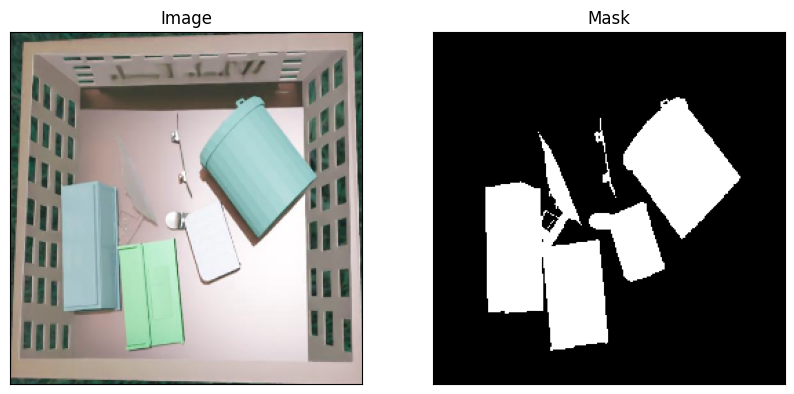

In [ ]:
img_num = random.randint(0, filtered_images_train.shape[0]-1)
example_image = dataset_train[img_num]["image"]
example_mask = dataset_train[img_num]["label"]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(np.array(example_image), cmap='gray')
axes[0].set_title("Image")

axes[1].imshow(example_mask, cmap='gray')
axes[1].set_title("Mask")

for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

plt.show()

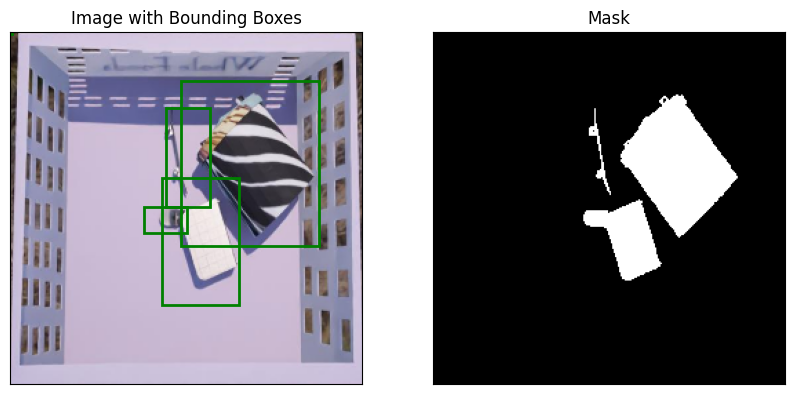

In [ ]:
import random
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as patches

img_num = random.randint(0, len(dataset_train) - 1)

example_image = dataset_train[img_num]["image"]
example_mask = dataset_train[img_num]["label"]
helperfns.draw_yolo_bboxes(bboxes_train[img_num], example_image, example_mask)


In [ ]:
from transformers import SamProcessor
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

In [ ]:
train_dataset = SAMDataset(dataset=dataset_train, processor=processor, bboxes = bboxes_train)
val_dataset = SAMDataset(dataset=dataset_val, processor=processor, bboxes = bboxes_val)

In [ ]:
example = train_dataset[0]
for k,v in example.items():
  print(k,v.shape)


pixel_values torch.Size([3, 1024, 1024])
original_sizes torch.Size([2])
reshaped_input_sizes torch.Size([2])
input_boxes torch.Size([1, 4])
ground_truth_mask (256, 256)


In [ ]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True, drop_last=False)
val_dataloader = DataLoader(val_dataset, batch_size=2, shuffle=True, drop_last=False)

In [ ]:
train_batch["ground_truth_mask"].shape

torch.Size([2, 256, 256])

In [ ]:
from transformers import SamModel
model = SamModel.from_pretrained("facebook/sam-vit-base")

for name, param in model.named_parameters():
  if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
    param.requires_grad_(False)

config.json:   0%|          | 0.00/6.57k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/375M [00:00<?, ?B/s]

In [ ]:
from torch.optim import Adam
import monai

optimizer = Adam(model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)

seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')

Validation Epoch 1/5: 100%|██████████| 10/10 [00:09<00:00,  1.06it/s]


EPOCH: 1/5
Mean Training Loss: 1.2561
Mean Validation Loss: 0.7821


Validation Epoch 2/5: 100%|██████████| 10/10 [00:10<00:00,  1.08s/it]


EPOCH: 2/5
Mean Training Loss: 0.6082
Mean Validation Loss: 0.4493


Validation Epoch 3/5: 100%|██████████| 10/10 [00:10<00:00,  1.03s/it]


EPOCH: 3/5
Mean Training Loss: 0.3566
Mean Validation Loss: 0.3415


Validation Epoch 4/5: 100%|██████████| 10/10 [00:10<00:00,  1.04s/it]


EPOCH: 4/5
Mean Training Loss: 0.2583
Mean Validation Loss: 0.2699


Validation Epoch 5/5: 100%|██████████| 10/10 [00:10<00:00,  1.03s/it]


EPOCH: 5/5
Mean Training Loss: 0.2128
Mean Validation Loss: 0.2320


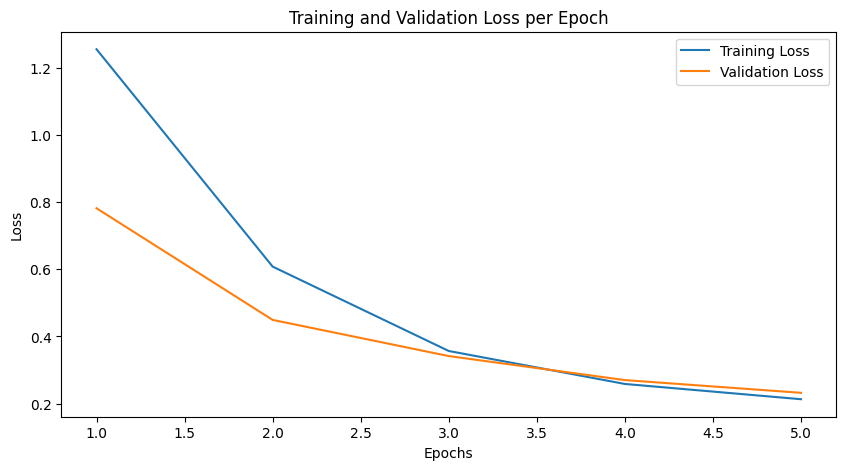

In [ ]:
from tqdm import tqdm
from statistics import mean
import torch
import matplotlib.pyplot as plt

num_epochs = 5
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    epoch_train_losses = []

    for batch in tqdm(train_dataloader, desc=f"Training Epoch {epoch+1}/{num_epochs}"):
        outputs = model(
            pixel_values=batch["pixel_values"].to(device),
            input_boxes=batch["input_boxes"].to(device),
            multimask_output=False
        )

        predicted_masks = outputs.pred_masks.squeeze(1)
        ground_truth_masks = batch["ground_truth_mask"].float().to(device)
        loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_train_losses.append(loss.item())

    mean_train_loss = mean(epoch_train_losses)
    train_losses.append(mean_train_loss)

    model.eval()
    epoch_val_losses = []

    with torch.no_grad():
        for batch in tqdm(val_dataloader, desc=f"Validation Epoch {epoch+1}/{num_epochs}"):
            outputs = model(
                pixel_values=batch["pixel_values"].to(device),
                input_boxes=batch["input_boxes"].to(device),
                multimask_output=False
            )

            predicted_masks = outputs.pred_masks.squeeze(1)
            ground_truth_masks = batch["ground_truth_mask"].float().to(device)
            val_loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))

            epoch_val_losses.append(val_loss.item())

    mean_val_loss = mean(epoch_val_losses)
    val_losses.append(mean_val_loss)

    print(f'EPOCH: {epoch+1}/{num_epochs}')
    print(f'Mean Training Loss: {mean_train_loss:.4f}')
    print(f'Mean Validation Loss: {mean_val_loss:.4f}')

plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label="Training Loss")
plt.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss per Epoch")
plt.legend()
plt.show()


In [ ]:
torch.save(model.state_dict(), ROOT_DIR + "SAM/model/best.pth")